In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score

In [2]:
import xgboost
from xgboost import XGBClassifier

In [3]:
train=pd.read_csv("./RefinedData/Training_dataset_Original.csv", low_memory=False)
test=pd.read_csv("./RefinedData/Evaluation_dataset.csv", low_memory=False)

In [4]:
def replace_nan(data):
    data = data.replace("nan", np.nan)
    data = data.replace("missing", np.nan)
    data = data.replace("na", np.nan)
    return data

In [5]:
train = replace_nan(train)
test = replace_nan(test)

In [6]:
def fill_data(data):
    data['mvar47'] = data['mvar47'] == 'C'
    data = data.astype(dtype='float64')
    data = data.fillna(data.median())
#     data = data.fillna(data.mean())
    return data

In [7]:
train = fill_data(train)
test = fill_data(test)

In [8]:
data=pd.concat([train, test], sort=False)
# data=pd.concat([train.drop('default_ind', axis=1), test])

In [9]:
test.head()

,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,...,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,570075.0,1860.0,0.4668,0.212,0.0,0.0,1621.0,151211.0,22298.0,161588.0,...,0.0,0.0,100.000,79.0105,0.00000,10.0,0.95597,0.0,0.0,1.0
1,570076.0,1797.0,0.4451,0.000,0.0,0.0,920.0,8124.0,920.0,30429.0,...,1.0,0.0,100.000,14.8880,0.00000,4.0,0.45250,0.0,0.0,1.0
2,570077.0,1826.0,0.0423,0.000,0.0,0.0,3478.0,7209.0,3964.0,16054.0,...,2.0,0.0,37.586,64.0020,0.09091,7.0,0.92384,0.0,0.0,1.0
3,570078.0,1656.0,0.2726,41.623,0.0,0.0,4955.0,4955.0,4955.0,65010.0,...,0.0,0.0,100.000,79.0105,0.52632,0.0,0.74912,0.0,0.0,0.0
4,570079.0,1915.0,0.4451,0.000,0.0,0.0,6918.0,7433.0,6918.0,7433.0,...,0.0,0.0,100.000,79.0105,0.00000,2.0,1.00000,0.0,0.0,0.0


In [10]:
def preparing_data(train,test):

    categorical = ["mvar16", "mvar34"]

    def replacing_categorical(X):
        x=train.groupby(X)["default_ind"].mean()
        y=train.groupby(X)["default_ind"].std()
#         data[X+str("_mean")]= data[X].apply(lambda X1: x[X1])
#         data[X+str("_std")] = data[X].apply(lambda X2: y[X2])

    for i in categorical:
        replacing_categorical(i)
   
    train_new = data.iloc[0:train.shape[0]]
    test_new = data.iloc[train.shape[0]:data.shape[0]]

    def prepare_data(df, is_train):
        # Dropping cm_key
#         df = df.drop(["application_id"], axis=1)
        # Dropping mvar1 due to uniformity
#         df  = df.drop(["mvar1"], axis=1)
        if is_train:
            return df.drop(['application_key',"default_ind"], axis=1), df['default_ind']
        return df.drop(['application_key',"default_ind"], axis=1)


    train_features, train_target = prepare_data(train_new, 1)
    test_features = prepare_data(test_new, 0)
    
    return train_features, train_target, test_features

In [11]:
train_features, train_target, test_features = preparing_data(train,test)

In [12]:
test_features.head()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,...,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,1860.0,0.4668,0.212,0.0,0.0,1621.0,151211.0,22298.0,161588.0,207987.0,...,0.0,0.0,100.000,79.0105,0.00000,10.0,0.95597,0.0,0.0,1.0
1,1797.0,0.4451,0.000,0.0,0.0,920.0,8124.0,920.0,30429.0,14070.0,...,1.0,0.0,100.000,14.8880,0.00000,4.0,0.45250,0.0,0.0,1.0
2,1826.0,0.0423,0.000,0.0,0.0,3478.0,7209.0,3964.0,16054.0,24924.0,...,2.0,0.0,37.586,64.0020,0.09091,7.0,0.92384,0.0,0.0,1.0
3,1656.0,0.2726,41.623,0.0,0.0,4955.0,4955.0,4955.0,65010.0,0.0,...,0.0,0.0,100.000,79.0105,0.52632,0.0,0.74912,0.0,0.0,0.0
4,1915.0,0.4451,0.000,0.0,0.0,6918.0,7433.0,6918.0,7433.0,14351.0,...,0.0,0.0,100.000,79.0105,0.00000,2.0,1.00000,0.0,0.0,0.0


In [13]:
def model(train,test):
    train_features, train_target, test_features = preparing_data(train,test)
    Xtrain, Xtest, ytrain, ytest = train_test_split( train_features, train_target,
                                                    stratify=train_target, test_size=.3, random_state=100)
    
    print(train_features.head())
#     train_features = train_features.values
#     test_features = test_features.values
    xgb = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
    xgb.fit(train_features, train_target)
    
    print ("Training :"+str(accuracy_score( ytrain, xgb.predict(Xtrain))))
    print ("Test :"+str(accuracy_score( ytest, xgb.predict(Xtest))))
    print ("ROC_AUC :"+str(roc_auc_score( ytest, xgb.predict(Xtest))))
    print ("precision_score :"+str(precision_score( ytest, xgb.predict(Xtest))))
    print ("recall_score :"+str(recall_score( ytest, xgb.predict(Xtest))))
    print ("confusion_matrix :"+ str(confusion_matrix(ytest, xgb.predict(Xtest))))

    def myscorer(cm):
        False1 = cm[0][1]
        False2 = cm[1][0]
        return (3*False1) + (False2), (False1+False2)

    print ("myscorer :"+ str(myscorer(confusion_matrix(ytest, xgb.predict(Xtest)))))
           
    ax = xgboost.plot_importance(xgb)
    fig = ax.figure
    fig.set_size_inches(15, 15)

In [14]:
# train = train.astype(dtype='float64')
# test = test.astype(dtype='float64')

    mvar1   mvar2  mvar3  mvar4  mvar5   mvar6    mvar7   mvar8    mvar9  \
0  1696.0  1.6541  0.000    0.0    0.0     0.0   6015.0   322.0  40369.0   
1  1846.0  0.8095  0.000    0.0    0.0   102.0   7532.0  3171.0  18234.0   
2  1745.0  0.4001  0.000    0.0    0.0   297.0   2536.0  2478.0  14171.0   
3  1739.0  0.2193  0.000    0.0    0.0  1982.0  26440.0  4955.0  20316.0   
4  1787.0  0.0118  0.225    0.0    0.0  5451.0   5494.0  5494.0   7987.0   

    mvar10   ...    mvar38  mvar39   mvar40   mvar41   mvar42  mvar43  \
0  18414.0   ...       4.0     1.0   73.780  82.5470  0.08696    10.0   
1  13664.0   ...       2.0     0.0   99.129  78.8835  0.00000    13.0   
2   2536.0   ...       1.0     0.0  100.000  29.2900  0.00000     1.0   
3  37013.0   ...       2.0     0.0   96.272  78.8835  0.15385     3.0   
4   4696.0   ...       2.0     0.0  115.019  78.8835  0.00000     1.0   

    mvar44  mvar45  mvar46  mvar47  
0  0.63899     0.0     0.0     1.0  
1  0.63836     0.0     0.0    

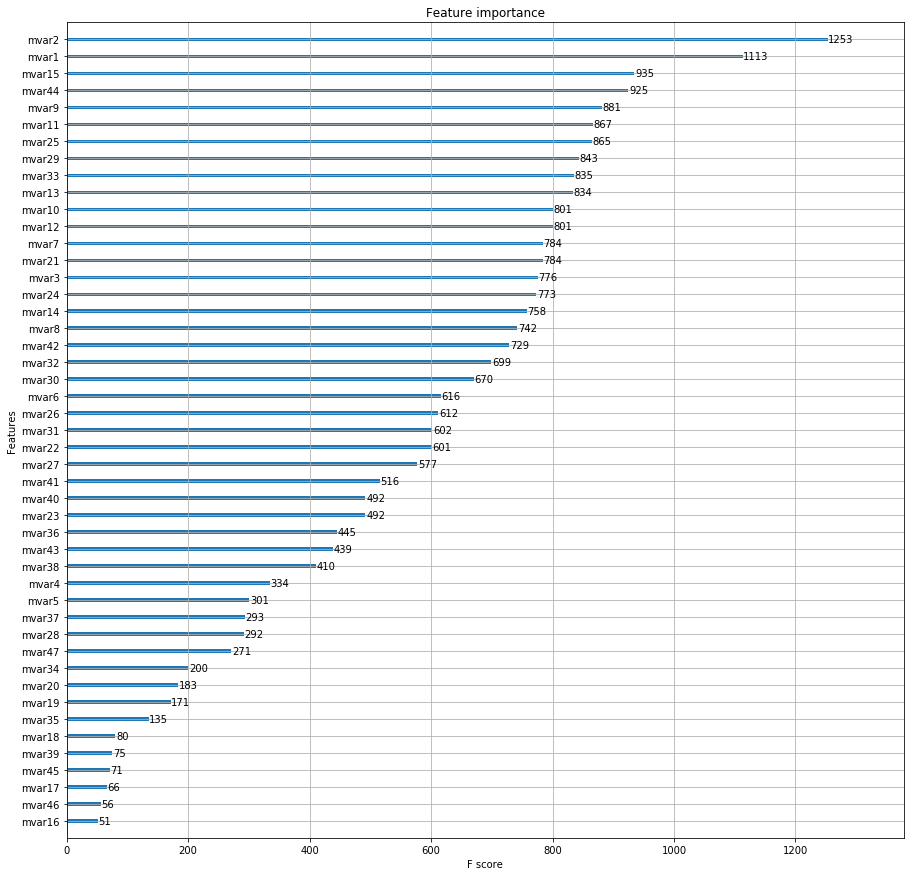

In [15]:
model(train, test)

In [16]:
train_features, train_target, test_features = preparing_data(train, test)
xgb = XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb.fit(train_features, train_target)
submission = pd.concat([test["application_key"], pd.DataFrame(xgb.predict_proba(test_features), columns=["0","1"])], axis=1)

In [17]:
# xgb.predict_proba(test_features)
test_features.shape

(25000, 47)

In [18]:
submission_pred = xgb.predict(test_features)

In [19]:
submission_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
submission.head()

,application_key,0,1
0,570075.0,0.982413,0.017587
1,570076.0,0.896569,0.103431
2,570077.0,0.973730,0.026270
3,570078.0,0.982755,0.017245
4,570079.0,0.989255,0.010745


In [21]:
# Y_pred=xgb1.predict(X_test)

In [23]:
# xgb1.predict_proba(X_test)

In [24]:
# float(np.sum(Y_pred == Y_test))/float(np.sum(Y_test == Y_test))

In [25]:
# metrics.accuracy_score(Y_test, Y_pred)

In [26]:
# X_lead = pd.read_csv('./RefinedData/refined_leaderboard_data.csv', low_memory=False)

In [27]:
# X_lead.head()

In [28]:
# Y_lead=pd.DataFrame(xgb1.predict(X_lead))

In [29]:
# Y_prob = xgb1.predict_proba(X_lead)
# Y_prob

In [22]:
submission

,application_key,0,1
0,570075.0,0.982413,0.017587
1,570076.0,0.896569,0.103431
2,570077.0,0.973730,0.026270
3,570078.0,0.982755,0.017245
4,570079.0,0.989255,0.010745
5,570080.0,0.938956,0.061044
6,570081.0,0.987220,0.012780
7,570082.0,0.696203,0.303797
8,570083.0,0.887007,0.112993
9,570084.0,0.956359,0.043641


In [23]:
# Y_wt = Y_prob[:,0]
Y_wt = submission.values[:, 1]
#Y_wt = np.abs(Y_wt - 0.5)
Y_wt

array([0.9824127 , 0.89656949, 0.97373015, ..., 0.86817247, 0.93236178,
       0.79503965])

In [24]:
sol = pd.DataFrame()
sol['priority'] = pd.Series(Y_wt)
sol['application_key'] = submission['application_key'].astype(dtype='int')
sol['default_ind'] = submission_pred.astype(dtype='int')

In [25]:
sol.head()

,priority,application_key,default_ind
0,0.982413,570075,0
1,0.896569,570076,0
2,0.973730,570077,0
3,0.982755,570078,0
4,0.989255,570079,0


In [26]:
sol = sol.sort_values(by = 'priority', ascending = False)
sol.head()

,priority,application_key,default_ind
6939,0.999729,577014,0
6809,0.999711,576884,0
3835,0.999706,573910,0
15473,0.999692,585548,0
1579,0.999686,571654,0


In [27]:
sol = sol.drop('priority', axis = 1)
sol.to_csv('./Analyzing_IITGuwahati.csv', index = False, header=False)